In [78]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable, functional
import torch.optim as optim
from torch.utils.data import Dataset, dataloader
from torchsummary import summary

import sys
sys.path.append('../src')
from model import *
from datagen import *
from analysis import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on GPU: ", device)
else:
    device = torch.device("cpu")
    print("Running on CPU")

torch.set_default_device(device)
# torch.cuda.synchronize()

Running on CPU


## Model

In [29]:
hidden_size = 128
input_size = 1
nav_size = 1

model1 = RNN_circular_LowEtAl_bridged(input_size,hidden_size,lr=0.0001,irnn=True,outputnn=False,Wx_normalize=False,activation=True,bias=False,nav_space=1,batch_size=64).to(device)

train = False

if train:
    _ = model1.train_gradual(epochs=4000)
    # model1.base_training_tsteps = 50
    # _ = model1.train(epochs=2000)
    model1.plot_losses(average=30)
else:
    model1.load_state_dict(torch.load("../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt"))

# torch.save(model1.state_dict(), "../trained models/LowEtAl_bridged_reduced_Gradual_lossiequaloroverj_maskonangle_lossscale_4000gradual.pt")

In [30]:
_ = model1.train(epochs=10)

100%|██████████| 10/10 [00:00<00:00, 29.19it/s]


## Analysis

### Norm of activity per timestep

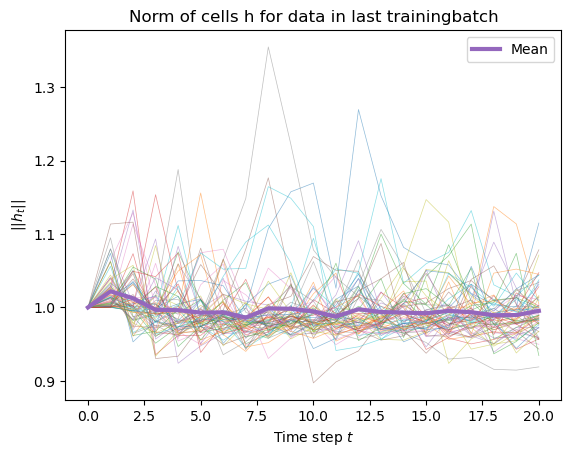

Mean norm:  0.9961278


In [31]:
def plot_norm(hts,avg_only=True):
    if avg_only:
        # Plot mean
        plt.plot(np.mean(hts,axis=1), linewidth=3, label="Mean")
    else:
        # Plot all in last batch
        plt.plot(hts, linewidth=0.5, alpha=0.5)
        # Plot mean
        plt.plot(np.mean(hts,axis=1), linewidth=3, label="Mean")
    plt.title("Norm of cells h for data in last trainingbatch")
    plt.xlabel(r"Time step $t$")
    plt.ylabel(r"$||h_t||$")
    plt.legend()
    plt.show()
    print("Mean norm: ", np.mean(hts))

htss = model1.hts.norm(dim=2)
htss = htss.cpu().detach().numpy()
plot_norm(htss,avg_only=False)

### Tuning curves

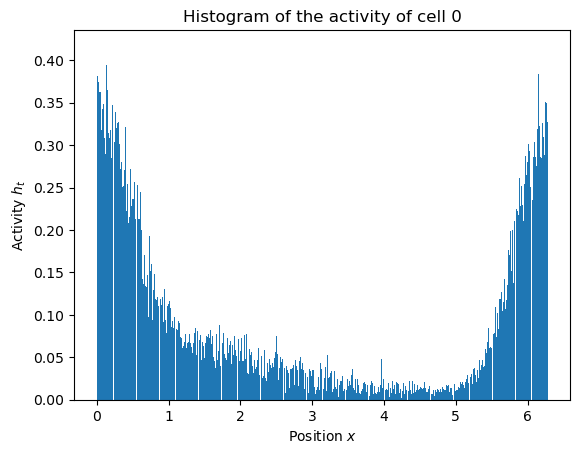

100%|██████████| 12/12 [00:16<00:00,  1.38s/it]


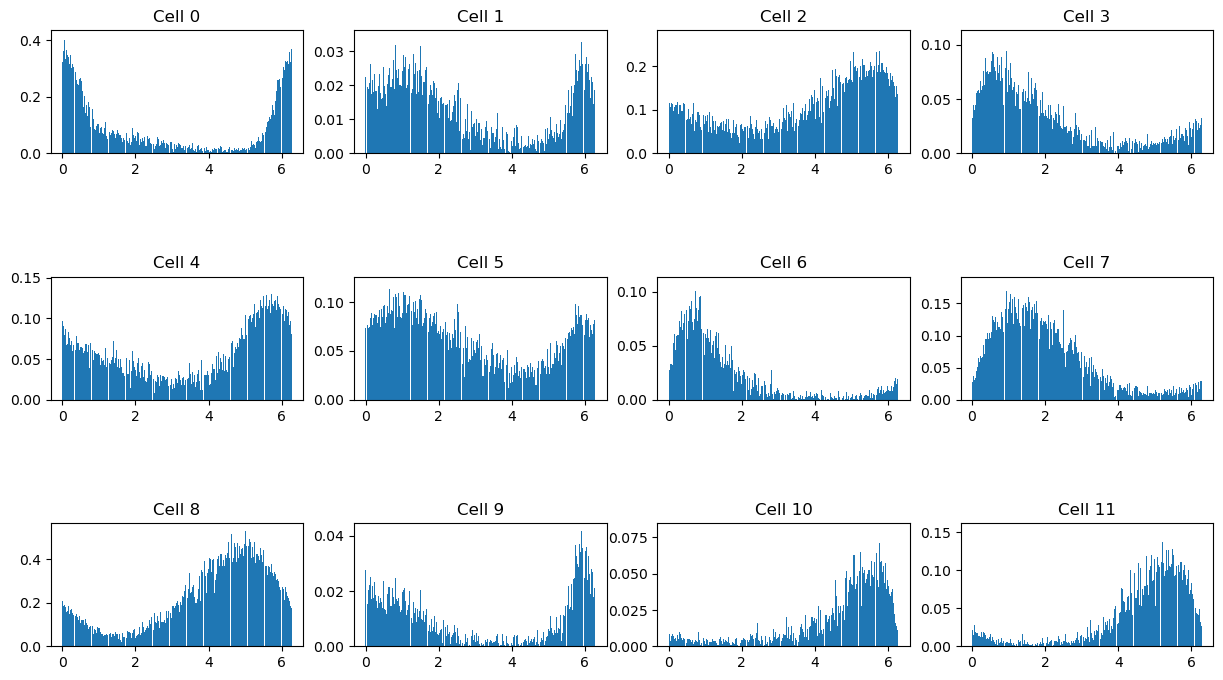

In [32]:
def tuning_curve(t_test=40,test_batch_size=5000, bins=2000, spherical_data=True):
    if spherical_data:
        data, _, labels = datagen_lowetal(5000,t_test)
    else:
        data,labels = datagen_circular_pm(5000,t_test,sigma=0.05,bound=0.5)
    
    
    # Get positions from labels
    xs = labels[0:test_batch_size]
    xs = xs.cpu().detach().numpy().T

    # Get the hidden states inferenced from the test data
    hts = model1(data[0:test_batch_size],raw=True)
    hts = hts.cpu().detach().numpy() # Shape [t_steps, batch_size, hidden_size] = [21, 64, 128]
    n_cells = hts.shape[2]
    
    import scipy.stats as stats

    activity = np.zeros((n_cells,bins))

    for k in range(n_cells):
        hts_k = abs(hts[1:,:,k])
        # Bins equally spaced from 0 to 1 in time_steps amount of bins
        bin_means, bin_edges, binnumber = stats.binned_statistic(xs.flatten(),hts_k.flatten(),statistic='mean',bins=bins)
        activity[k,:] = bin_means
        np.nan_to_num(activity,copy=False)
    return activity, bin_edges

def plot_tuning_curve(activity,bin_edges,k,spherical=False,linear=False,plot_head_frac=1/10,scale_to_one=False):
    if scale_to_one:
        scaler = 1/(2*np.pi)
    else:
        scaler = 1

    bin_edges = bin_edges*scaler
    bins = len(bin_edges)

    n_cells = activity.shape[0]

    # Plot single cell
    plt.bar(bin_edges[:-1],activity[k,:],width=6/bins)
    plt.title("Histogram of the activity of cell "+str(k))
    plt.xlabel(r"Position $x$")
    plt.ylabel(r"Activity $h_t$")
    plt.show()

    if spherical:
        fig, ax = plt.subplots(int(32*plot_head_frac),4,subplot_kw={'projection': 'polar'})
        fig.set_size_inches(15, 80*plot_head_frac)
        fig.subplots_adjust(hspace=0.5)
        for k in tqdm(range(int(n_cells*plot_head_frac))):
            ax[k//4,k%4].bar(bin_edges[:-1]*2*np.pi,activity[k,:],width=6/bins,alpha=1)
            ax[k//4,k%4].set_title("Cell "+str(k))
        plt.show()
    
    # Plot all cells linearly
    if linear:
        fig, ax = plt.subplots(int(32*plot_head_frac),4)
        fig.set_size_inches(15, 80*plot_head_frac)
        fig.subplots_adjust(hspace=1,wspace=0.2)
        for k in tqdm(range(int(n_cells*plot_head_frac))):
            ax[k//4,k%4].bar(bin_edges[:-1],activity[k,:],width=6/bins)
            ax[k//4,k%4].set_title("Cell "+str(k))
        plt.show()




activity, bin_edges = tuning_curve()
plot_tuning_curve(activity,bin_edges,0,spherical=False,linear=True,scale_to_one=True)

### Low dimensional representations

Explained variance for PCA with 2 components: 0.9260503871368639 %


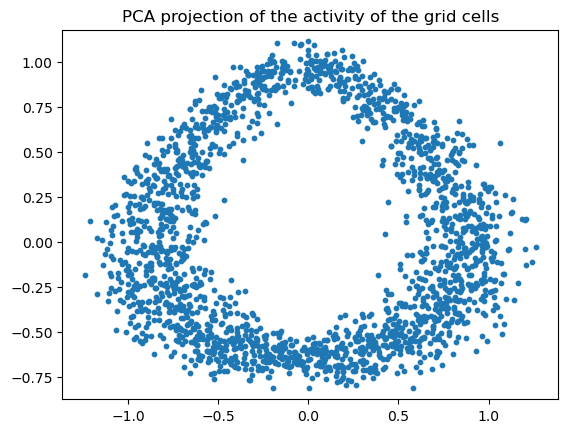

In [77]:
def lowD_reduce(activity,if_pca=True,n_components=2,plot=True):
    if if_pca:
        from sklearn.decomposition import PCA

        reducer = PCA(n_components=n_components)
        reducer.fit(activity.T)
        embedding = reducer.transform(activity.T)
        # Explained variance
        print(f"Explained variance for PCA with {n_components} components:", np.sum(reducer.explained_variance_ratio_), "%")
        if plot and n_components==2:
            plt.scatter(embedding[:,0],embedding[:,1],s=10)
            plt.gca().set_aspect('equal', 'datalim')
            plt.title('PCA projection of the activity of the grid cells', fontsize=12)
            plt.show()
        else:
            import plotly.express as px
            fig = px.scatter_3d(embedding, x=0, y=1, z=2)
            fig.show()
    else:
        # UMAP
        import umap
        reducer = umap.UMAP(n_neighbors=500, n_components=2)
        reducer.fit(activity.T)
        embedding = reducer.transform(activity.T)
        if plot and n_components==2:
            plt.scatter(embedding[:,0],embedding[:,1],s=10)
            plt.gca().set_aspect('equal', 'datalim')
            plt.title('UMAP projection of the activity of the grid cells', fontsize=12)
            plt.show()
        else:
            import plotly.express as px
            fig = px.scatter_3d(embedding, x=0, y=1, z=2)
            fig.show()

    return embedding, reducer


embedding, reducer = lowD_reduce(activity,if_pca=True,n_components=2,plot=True)

### Accuracy testing

In [42]:
def test_angle_inference(reducer,t_test=40,test_batch_size=1000):
    # Same datagen as in training
    data,labels = datagen_circular_pm(test_batch_size,t_test,sigma=0.05,bound=0.5)

    # Inference model to get the hidden states
    y_hat = model1(data[0:test_batch_size],raw=True)
    y_hat = y_hat.permute(1,0,2)
    y_hat = y_hat.cpu().detach().numpy()

    # PCA projection of the hidden states to 2D space for calculation of angles
    y_hat_pca = np.zeros((test_batch_size,t_test+1,2))
    for i in range(test_batch_size):
        y_hat_pca[i,:,:] = reducer.transform(y_hat[i,:,:])
    y_hat = y_hat_pca

    # Get theoretical angles from labels
    y = labels[0:test_batch_size]
    y = y.cpu().detach().numpy()
    # Concatenate pi to the start of y to represent starting angle
    y = np.concatenate((np.ones((test_batch_size,1))*np.pi,y),axis=-1)

    # Error between predicted and theoretical angles
    err = np.zeros((test_batch_size,t_test))
    # Angles predicted by the model
    angs = np.zeros((test_batch_size,t_test))
    # Theoretical angle differences
    dy = np.zeros((test_batch_size,t_test))

    # Calculate angle differences from cosine distance
    for j in range(test_batch_size):
        for i in range(1,t_test+1):
            y_hat_i_normalized = y_hat[j,i]/np.linalg.norm(y_hat[j,i])
            y_hat_i_minus_1_normalized = y_hat[j,i-1]/np.linalg.norm(y_hat[j,i-1])
            # Angle between y_hat[j,i] and y_hat[j,i-1]
            ang = np.arccos(y_hat_i_normalized @ y_hat_i_minus_1_normalized)
            # Use cross product to determine direction/sign of angle change
            angle_direction = np.sign(np.cross(y_hat_i_normalized,y_hat_i_minus_1_normalized))
            angs[j,i-1] = ang*angle_direction
            
            # Angle differance from labels
            dy[j,i-1] = y[j,i]-y[j,i-1]

    # For some reason we have to scale angles by 2*pi
    angs = angs*(2*np.pi)
    # Choose the sign of the angles that gives the smallest error
    ang_plus = angs
    ang_minus = -angs
    err_plus = np.abs(dy-ang_plus)
    err_minus = np.abs(dy-ang_minus)
    if np.mean(err_plus) < np.mean(err_minus):
        err = err_plus
        angs = ang_plus
    else:
        err = err_minus
        angs = ang_minus

    print("Mean error: ",np.mean(np.abs(angs-dy)))
    return angs, dy, err, y_hat, y

angs, dy, err, y_hat, y = test_angle_inference(reducer)


Mean error:  0.118144929265773


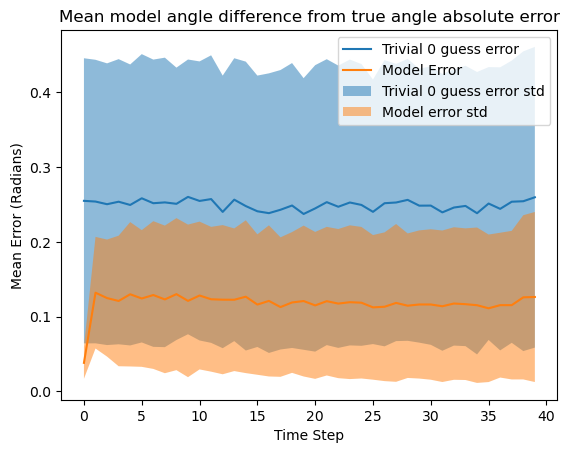

In [46]:
def plot_accuracy(angs,dy,y_hat,y):
    err = np.abs(angs - dy)
    err_mean = np.mean(err,axis=0)
    err_mean_std = np.std(err,axis=0)
    dy_mean = np.mean(np.abs(dy-0),axis=0)
    dy_mean_std = np.std(np.abs(dy-0),axis=0)
    t_test = err.shape[1]
    # trivial_mean_error = np.mean(np.abs(dy - dy_mean),axis=0)
    plt.plot(dy_mean,label="Trivial 0 guess error")
    plt.plot(err_mean,label="Model Error")
    plt.fill_between(np.arange(t_test),dy_mean-dy_mean_std,dy_mean+dy_mean_std,alpha=0.5, label="Trivial 0 guess error std")
    plt.fill_between(np.arange(t_test),err_mean-err_mean_std,err_mean+err_mean_std,alpha=0.5, label="Model error std")
    plt.legend()
    plt.title("Mean model angle difference from true angle absolute error")
    plt.xlabel("Time Step")
    plt.ylabel("Mean Error (Radians)")
    plt.show()

plot_accuracy(angs,dy,y_hat,y)

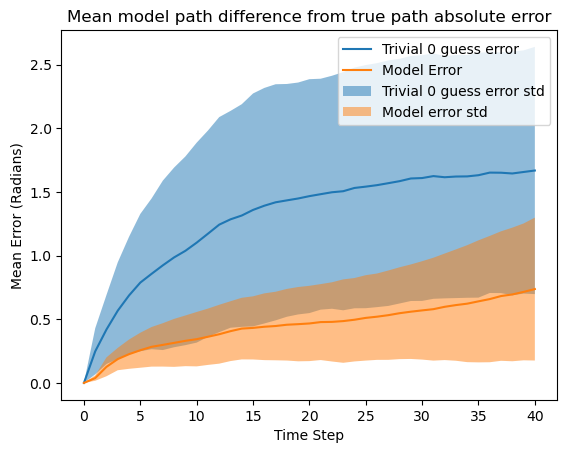

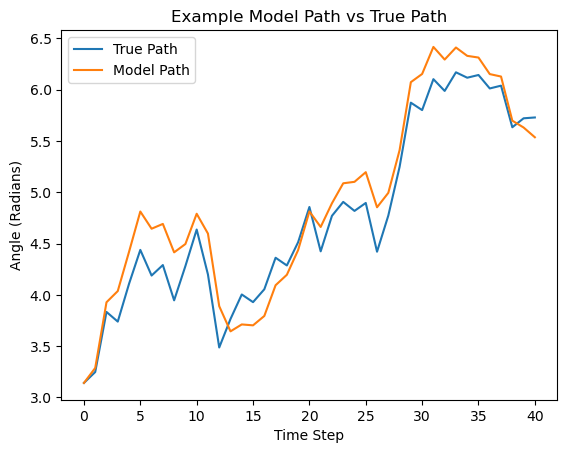

In [60]:
def plot_path_accuracy(angs,y,example_path=0):
    # Integrate angles to get path
    path = np.zeros((angs.shape[0],angs.shape[1]+1))
    path[:,0] = np.pi
    for i in range(1,angs.shape[1]+1):
        path[:,i] = path[:,i-1] + angs[:,i-1]
    # Calculate path error
    path_err = np.abs(path-y)
    path_err_mean = np.mean(path_err,axis=0)
    path_err_mean_std = np.std(path_err,axis=0)
    t_test = path_err.shape[1]
    # Calculate trivial path error
    y_mean = np.mean(np.abs(y-0),axis=0)
    y_mean_std = np.std(np.abs(y-0),axis=0)
    trivial_path_err = np.abs(path-y_mean)
    trivial_path_err_mean = np.mean(trivial_path_err,axis=0)
    trivial_path_err_mean_std = np.std(trivial_path_err,axis=0)
    # Plot
    plt.plot(trivial_path_err_mean,label="Trivial 0 guess error")
    plt.plot(path_err_mean,label="Model Error")
    plt.fill_between(np.arange(t_test),trivial_path_err_mean-trivial_path_err_mean_std,trivial_path_err_mean+trivial_path_err_mean_std,alpha=0.5, label="Trivial 0 guess error std")
    plt.fill_between(np.arange(t_test),path_err_mean-path_err_mean_std,path_err_mean+path_err_mean_std,alpha=0.5, label="Model error std")
    plt.legend()
    plt.title("Mean model path difference from true path absolute error")
    plt.xlabel("Time Step")
    plt.ylabel("Mean Error (Radians)")
    plt.show()

    # Plot example path
    plt.plot(y[example_path,:],label="True Path")
    plt.plot(path[example_path,:],label="Model Path")
    plt.legend()
    plt.title("Example Model Path vs True Path")
    plt.xlabel("Time Step")
    plt.ylabel("Angle (Radians)")
    plt.show()
    
plot_path_accuracy(angs,y,example_path=1)